In [6]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
%cd gdrive/My Drive/Defi\ Project/dataset
%ls

/content/gdrive/My Drive/Defi Project/dataset
test.csv  train.csv


In [8]:
import pandas
import numpy as np
import xgboost as xgb
import ast
import csv
import matplotlib.pyplot as plt

In [9]:
def convert_dataset(dataset):
  examples = []
  for blob in dataset['txData']:
    txData = ast.literal_eval(blob)
    examples.append([int(txData['from'], 0) % (2 ** 30),
      (int(txData['to'], 0) if txData['to'] is not None else 0) % (2 ** 30),
      int(txData['gas'], 0),
      int(txData['gasPrice'], 0),
      (int(txData['input'][:10], 0) if txData['input'] != '0x' else 0) % (2 ** 30),
      int(txData['nonce'], 0),
    ])
  return np.array(examples)

In [10]:
import sys

csv.field_size_limit(sys.maxsize)

train = pandas.read_csv('train.csv',quoting=csv.QUOTE_NONE,error_bad_lines=False )
test = pandas.read_csv('test.csv',quoting=csv.QUOTE_NONE,error_bad_lines=False)

b'Skipping line 8: expected 22 fields, saw 92\nSkipping line 9: expected 22 fields, saw 112\nSkipping line 13: expected 22 fields, saw 32\nSkipping line 20: expected 22 fields, saw 152\nSkipping line 21: expected 22 fields, saw 204\nSkipping line 22: expected 22 fields, saw 92\nSkipping line 30: expected 22 fields, saw 32\nSkipping line 31: expected 22 fields, saw 32\nSkipping line 33: expected 22 fields, saw 42\nSkipping line 40: expected 22 fields, saw 92\nSkipping line 44: expected 22 fields, saw 102\nSkipping line 45: expected 22 fields, saw 152\nSkipping line 48: expected 22 fields, saw 101\nSkipping line 52: expected 22 fields, saw 52\nSkipping line 59: expected 22 fields, saw 152\nSkipping line 61: expected 22 fields, saw 32\nSkipping line 62: expected 22 fields, saw 82\nSkipping line 64: expected 22 fields, saw 782\nSkipping line 66: expected 22 fields, saw 132\nSkipping line 67: expected 22 fields, saw 92\nSkipping line 70: expected 22 fields, saw 32\nSkipping line 75: expecte

In [11]:
print(type(train['Label0'].to_numpy()))
train_labels = train['Label0'].to_numpy()
print(train_labels)
train_labels = np.array([False if i == "False" or i == 0 else True for i in train_labels])
print(train_labels)
for i in range(100):
  print(train_labels[i])


<class 'numpy.ndarray'>
['False' 'False' 'False' ... 'False' 'False' 'False']
[False False False ... False False False]
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [12]:

def fix_data(dataset, labels=None):
  examples = []
  l = []
  counter = -1
  for index, row in dataset.iterrows():
    counter += 1
    g = 0
    txData = {}
    while g < len(index):
      if not type(index[g]) == type("yo"):
        g+=1 
        continue
      if 'from' in index[g]:
        txData['from'] = index[g][10:-1] 
      if 'to' in index[g]:
        txData['to'] = index[g][8:-1]
        if 'on' in txData['to']:
          g+=1
          txData = {}
          continue
      if 'gas' in index[g]:
        txData['gas'] = index[g][9:-1]
        if 'of' in txData['gas']:
          txData['gas'] = '0x0' 
        if txData['gas'][0] != '0':
          txData['gas'] = txData['gas'][4:]
      if 'gasPrice' in index[g]:
        txData['gasPrice'] = index[g][14:-1]
      if 'input' in index[g]:
        txData['input'] = index[g][11:-1]
      if 'nonce' in index[g]:
        txData['nonce'] = index[g][11:-1]
      g+=1

    if len(txData) < 6:
      continue
    if labels is not None:
      l.append(labels[counter])
    examples.append([int(txData['from'],0) % (2 ** 30), 
        (int(txData['to'], 0) if txData['to'] is not None else 0) % (2 ** 30),
        int(txData['gas'], 0),
        int(txData['gasPrice'], 0),
        (int(txData['input'][:10], 0) if txData['input'] != '0x' else 0) % (2 ** 30),
        int(txData['nonce'], 0),
      ])
  print(examples[:10])
  return np.array(examples), l

In [15]:
train_fix, final_labels = fix_data(train, train_labels)
test_fix, _ = fix_data(test)

[[793498831, 233934695, 0, 160000000000, 0, 464938], [902328673, 568723511, 29000, 157300000000, 0, 11727], [876794737, 1032003271, 70622, 150000000000, 688233659, 70], [902328673, 380982458, 29000, 157300000000, 0, 11728], [829320287, 990762854, 0, 150000000000, 0, 197], [357089495, 1036369951, 0, 144000000000, 0, 53713], [214980982, 877093190, 0, 145000000000, 0, 1], [512516981, 776170574, 86492, 131000000000, 688233659, 21], [540716269, 985361716, 186128, 174000000000, 0, 4790108], [883554816, 154595518, 21000, 160000000000, 0, 276]]
[[906423112, 1011662287, 72552, 39000000000, 815825457, 2569], [168127469, 168127469, 0, 27000000000, 0, 7], [707105652, 707105652, 0, 27000000000, 0, 16], [435308685, 645354486, 2504, 26400000000, 151187884, 0], [678914863, 357089495, 0, 36000000000, 0, 0], [500454642, 382380581, 27951, 35000000000, 688233659, 4], [1005353282, 974067923, 0, 26000000000, 0, 21], [469080552, 16137073, 0, 1000000000, 0, 2815323], [469080552, 871341405, 0, 1000000000, 0, 2

In [ ]:
binaryModel = xgb.XGBClassifier(n_estimators=50)
binaryModel.fit(train_fix, final_labels)
binaryPredictions = binaryModel.predict_proba(test_fix)[:, 1]

Random Forest Approach

In [ ]:
regressionModel = xgb.XGBRegressor(n_estimators=50)
regressionModel.fit(
  train_fix,
  final_labels
)
regressionPredictions = regressionModel.predict(test_fix)

[04:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
!pip install EthTx

In [ ]:
import EthTx
from confidential.json import MONGO_CON_STR, MONGO_DB, ETHERSCAN_API, HOOK, POA
from collections import Counter

ethtx_config = EthTxConfig(
    mongo_connection_string=MONGO_CON_STR
    mongo_database = MONGO_DB
    etherscan_api_key = ETHERSCAN_API
    web3nodes = {
                "mainnet": {
                    "hook": HOOK
                    "poa": POA
                }
            },
            default_chain = "mainnet",
            etherscan_urls = {"mainnet": "https://api.etherscan.io/api",},
)

ethtx = EthTx.initialize(ethtx_config)
web3provider = ethtx.providers.web3provider

from ethtx.models.w3_model import W3Transaction, W3Block, W3Receipt, W3CallTree

def add_more_data(train_fix):
  for tx in train_fix:
    txID = tx[4]
    # read raw tx data
    w3transaction: W3Transaction = web3provider.get_transaction(txID)
    w3block: W3Block = web3provider.get_block(w3transaction.blockNumber)
    w3receipt: W3Receipt = web3provider.get_receipt(w3transaction.hash.hex())
    w3calls: W3CallTree = web3provider.get_calls(w3transaction.hash.hex()
    # what tokens were in tx and how many
    tokens = Counter(w3receipt.get_tokens())
    tx.append(tokens["DAI"])
    tx.append(tokens["ETH"])
    tx.append(tokens["WETH"])
    tx.append(tokens["BTC"])
    tx.append(tokens["WBTC"])
    # block #
    tx.append(w3transaction.blockNumber)

# uncomment to add the data
# add_more_data(train_fix)

In [ ]:
# WE GOT THIS CODE FROM THE FOLLOWING GITHUB: https://github.com/iridiumblue/roc-star
def roc_star_loss( _y_true, y_pred, gamma, _epoch_true, epoch_pred):
  """
  Nearly direct loss function for AUC.
  See article,
  C. Reiss, "Roc-star : An objective function for ROC-AUC that actually works."
  https://github.com/iridiumblue/articles/blob/master/roc_star.md
      _y_true: `Tensor`. Targets (labels).  Float either 0.0 or 1.0 .
      y_pred: `Tensor` . Predictions.
      gamma  : `Float` Gamma, as derived from last epoch.
      _epoch_true: `Tensor`.  Targets (labels) from last epoch.
      epoch_pred : `Tensor`.  Predicions from last epoch.
  """
  #convert labels to boolean
  y_true = (_y_true>=0.50)
  epoch_true = (_epoch_true>=0.50)

  # if batch is either all true or false return small random stub value.
  if torch.sum(y_true)==0 or torch.sum(y_true) == y_true.shape[0]: return torch.sum(y_pred)*1e-8

  pos = y_pred[y_true]
  neg = y_pred[~y_true]

  epoch_pos = epoch_pred[epoch_true]
  epoch_neg = epoch_pred[~epoch_true]

  # Take random subsamples of the training set, both positive and negative.
  max_pos = 1000 # Max number of positive training samples
  max_neg = 1000 # Max number of positive training samples
  cap_pos = epoch_pos.shape[0]
  cap_neg = epoch_neg.shape[0]
  epoch_pos = epoch_pos[torch.rand_like(epoch_pos) < max_pos/cap_pos]
  epoch_neg = epoch_neg[torch.rand_like(epoch_neg) < max_neg/cap_pos]

  ln_pos = pos.shape[0]
  ln_neg = neg.shape[0]

  # sum positive batch elements agaionst (subsampled) negative elements
  if ln_pos>0 :
      pos_expand = pos.view(-1,1).expand(-1,epoch_neg.shape[0]).reshape(-1)
      neg_expand = epoch_neg.repeat(ln_pos)

      diff2 = neg_expand - pos_expand + gamma
      l2 = diff2[diff2>0]
      m2 = l2 * l2
      len2 = l2.shape[0]
  else:
      m2 = torch.tensor([0], dtype=torch.float).cuda()
      len2 = 0

  # Similarly, compare negative batch elements against (subsampled) positive elements
  if ln_neg>0 :
      pos_expand = epoch_pos.view(-1,1).expand(-1, ln_neg).reshape(-1)
      neg_expand = neg.repeat(epoch_pos.shape[0])

      diff3 = neg_expand - pos_expand + gamma
      l3 = diff3[diff3>0]
      m3 = l3*l3
      len3 = l3.shape[0]
  else:
      m3 = torch.tensor([0], dtype=torch.float).cuda()
      len3=0

  if (torch.sum(m2)+torch.sum(m3))!=0 :
      res2 = torch.sum(m2)/max_pos+torch.sum(m3)/max_neg
      #code.interact(local=dict(globals(), **locals()))
  else:
      res2 = torch.sum(m2)+torch.sum(m3)

  res2 = torch.where(torch.isnan(res2), torch.zeros_like(res2), res2)

  return res2

def epoch_update_gamma(y_true,y_pred, epoch=-1,delta=2):
  """
  Calculate gamma from last epoch's targets and predictions.
  Gamma is updated at the end of each epoch.
  y_true: `Tensor`. Targets (labels).  Float either 0.0 or 1.0 .
  y_pred: `Tensor` . Predictions.
  """
  DELTA = delta
  SUB_SAMPLE_SIZE = 2000.0
  pos = y_pred[y_true==1]
  neg = y_pred[y_true==0] # yo pytorch, no boolean tensors or operators?  Wassap?
  # subsample the training set for performance
  cap_pos = pos.shape[0]
  cap_neg = neg.shape[0]
  pos = pos[torch.rand_like(pos) < SUB_SAMPLE_SIZE/cap_pos]
  neg = neg[torch.rand_like(neg) < SUB_SAMPLE_SIZE/cap_neg]
  ln_pos = pos.shape[0]
  ln_neg = neg.shape[0]
  pos_expand = pos.view(-1,1).expand(-1,ln_neg).reshape(-1)
  neg_expand = neg.repeat(ln_pos)
  diff = neg_expand - pos_expand
  ln_All = diff.shape[0]
  Lp = diff[diff>0] # because we're taking positive diffs, we got pos and neg flipped.
  ln_Lp = Lp.shape[0]-1
  diff_neg = -1.0 * diff[diff<0]
  diff_neg = diff_neg.sort()[0]
  ln_neg = diff_neg.shape[0]-1
  ln_neg = max([ln_neg, 0])
  left_wing = int(ln_Lp*DELTA)
  left_wing = max([0,left_wing])
  left_wing = min([ln_neg,left_wing])
  default_gamma=torch.tensor(0.2, dtype=torch.float).cuda()
  if diff_neg.shape[0] > 0 :
      gamma = diff_neg[left_wing]
  else:
      gamma = default_gamma # default=torch.tensor(0.2, dtype=torch.float).cuda() #zoink
  L1 = diff[diff>-1.0*gamma]
  ln_L1 = L1.shape[0]
  if epoch > -1 :
      return gamma
  else :
      return default_gamma

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Network2(torch.nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.f1 = nn.Linear(6,10)
        self.f2 = nn.Linear(10,10)
        self.f3 = nn.Linear(10,1)
        self.relu = torch.nn.ReLU() # instead of Heaviside step fn
        # self.sig = torch.nn.Sigmoid()
    def forward(self, x):
        out = self.f1(x.float())
        out = self.relu(out)
        out = self.f2(out)
        out = self.relu(out)
        out = self.f3(out) 
        # out = self.sig(out)
        # print(out)
        # out = torch.round(out)
        # print(out)
        return out

class Network4(torch.nn.Module):
    def __init__(self):
        super(Network4, self).__init__()
        self.f1 = nn.Linear(6,20)
        self.f2 = nn.Linear(20,20)
        self.f3 = nn.Linear(20,1)
        self.relu = torch.nn.ReLU() # instead of Heaviside step fn
    def forward(self, x):
        out = self.f1(x.float())
        out = self.relu(out)
        out = self.f2(out)
        out = self.relu(out) 
        out = self.f3(out) 
        return out

class Network6(torch.nn.Module):
    def __init__(self):
        super(Network6, self).__init__()
        self.f1 = nn.Linear(6,30)
        self.f2 = nn.Linear(30,30)
        self.f3 = nn.Linear(30,1)
        self.relu = torch.nn.ReLU() # instead of Heaviside step fn
    def forward(self, x):
        out = self.f1(x.float())
        out = self.relu(out)
        out = self.f2(out)
        out = self.relu(out) 
        out = self.f3(out)  
        return out

In [16]:
# count = 0
pos_idx = []
neg_idx = []
idx = 0
for i in final_labels:
  if i == True:
    pos_idx.append(idx)
  else:
    neg_idx.append(idx)
  idx += 1
print(len(pos_idx))
print(len(neg_idx))
use_idx = pos_idx[:17000] + neg_idx[:17000] 

28374
88688


In [ ]:
model = Network2()
criterion = torch.nn.BCEWithLogitsLoss()
# UNCOMMENT FOR MSE LOSS
# criterion = torch.nn.MSELoss()
# UNCOMMENT FOR ROC LOSS
# criterion = roc_star_loss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0458)
print(train_fix.shape)
losses2 = []
for epoch in range(300):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(torch.tensor(train_fix[use_idx]))
    # Compute Loss
    ll = torch.tensor(final_labels)[use_idx].float()
    loss = criterion(y_pred.squeeze(), torch.tensor(final_labels)[use_idx].float())
    if epoch % 20 == 0:
      print('Epoch {}: train loss: {}'.format(epoch, np.abs(np.log(loss.item()))))
    # Backward pass
    losses2.append(np.abs(np.log(loss.item())))
    loss.backward()
    optimizer.step()

(117062, 6)
Epoch 0: train loss: 21.141809080448482
Epoch 20: train loss: 0.12828089200003326
Epoch 40: train loss: 0.13256520534705654
Epoch 60: train loss: 0.1359028235442938
Epoch 80: train loss: 0.13651059607074403
Epoch 100: train loss: 0.13649907332630826
Epoch 120: train loss: 0.1365127458511934
Epoch 140: train loss: 0.13651300382515788
Epoch 160: train loss: 0.13651300382515788
Epoch 180: train loss: 0.1365127458511934
Epoch 200: train loss: 0.136512917833829
Epoch 220: train loss: 0.13651300382515788
Epoch 240: train loss: 0.13651300382515788
Epoch 260: train loss: 0.13651317580783787
Epoch 280: train loss: 0.136512917833829


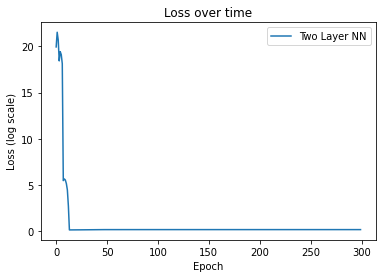

In [ ]:
def plot_losses(losses, names):
    for j in range(len(losses)):
        loss = losses[j]
        name = names[j]
        x = []
        y = []
        for i in range(300):
            if not np.isnan(loss[i]) and loss[i] < np.Inf:
                x.append(i)
                y.append(loss[i])
        plt.plot(x, y, label=name)
        
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()

plot_losses([losses], ["Two Layer NN"])

In [24]:
model = Network4()

print(train_fix.shape)
losses4 = []
for epoch in range(300):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(torch.tensor(train_fix[use_idx]))
    # Compute Loss
    ll = torch.tensor(final_labels)[use_idx].float()
    loss = criterion(y_pred.squeeze(), torch.tensor(final_labels)[use_idx].float())
    if epoch % 20 == 0:
      print('Epoch {}: train loss: {}'.format(epoch, np.abs(np.log(loss.item())-21.25)))
    # Backward pass
    losses4.append(np.abs(np.log(loss.item())))
    loss.backward()
    optimizer.step()

(117062, 6)
Epoch 0: train loss: 0.23440064363678914
Epoch 20: train loss: 0.23440064363678914
Epoch 40: train loss: 0.23440064363678914
Epoch 60: train loss: 0.23440064363678914
Epoch 80: train loss: 0.23440064363678914
Epoch 100: train loss: 0.23440064363678914
Epoch 120: train loss: 0.23440064363678914
Epoch 140: train loss: 0.23440064363678914
Epoch 160: train loss: 0.23440064363678914
Epoch 180: train loss: 0.23440064363678914
Epoch 200: train loss: 0.23440064363678914
Epoch 220: train loss: 0.23440064363678914
Epoch 240: train loss: 0.23440064363678914
Epoch 260: train loss: 0.23440064363678914
Epoch 280: train loss: 0.23440064363678914


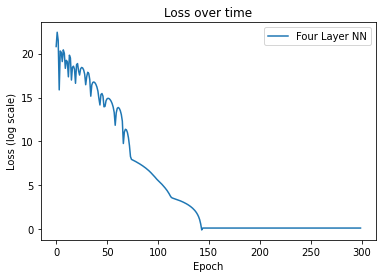

In [ ]:
def plot_losses(losses, names):
    for j in range(len(losses)):
        loss = losses[j]
        name = names[j]
        x = []
        y = []
        for i in range(300):
            if not np.isnan(loss[i]) and loss[i] < np.Inf:
                x.append(i)
                y.append(loss[i])
        plt.plot(x, y, label=name)
        
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()

plot_losses([losses], ["Four Layer NN"])

In [ ]:
model = Network6()
print(train_fix.shape)
losses6 = []
for epoch in range(300):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(torch.tensor(train_fix[use_idx]))
    # Compute Loss
    ll = torch.tensor(final_labels)[use_idx].float()
    loss = criterion(y_pred.squeeze(), torch.tensor(final_labels)[use_idx].float())
    if epoch % 20 == 0:
      print('Epoch {}: train loss: {}'.format(epoch, np.abs(np.log(loss.item()))))
    # Backward pass
    losses6.append(np.abs(np.log(loss.item())))
    loss.backward()
    optimizer.step()

(117062, 6)
Epoch 0: train loss: 19.952034790205506
Epoch 20: train loss: 0.10328410664575927
Epoch 40: train loss: 0.10967150284039456
Epoch 60: train loss: 0.11045745496717141
Epoch 80: train loss: 0.1104983854054673
Epoch 100: train loss: 0.11051102602646418
Epoch 120: train loss: 0.11051300382515789
Epoch 140: train loss: 0.11051257386858737
Epoch 160: train loss: 0.11051300382515789
Epoch 180: train loss: 0.11051300382515789
Epoch 200: train loss: 0.11051300382515789
Epoch 220: train loss: 0.11051300382515789
Epoch 240: train loss: 0.110512917833829
Epoch 260: train loss: 0.110512917833829
Epoch 280: train loss: 0.110512917833829


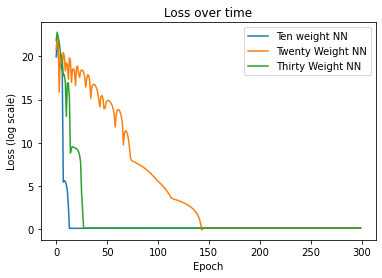

In [ ]:
def plot_losses(losses, names):
    for j in range(len(losses)):
        loss = losses[j]
        name = names[j]
        x = []
        y = []
        for i in range(300):
            if not np.isnan(loss[i]) and loss[i] < np.Inf:
                x.append(i)
                y.append(loss[i])
        plt.plot(x, y, label=name)
        
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()

plot_losses([losses2,losses4, losses6], ["Ten weight NN","Twenty Weight NN","Thirty Weight NN"])

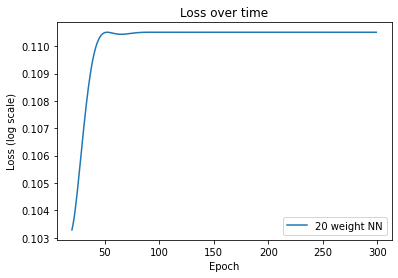

In [ ]:
def plot_losses_small(losses, names):
    for j in range(len(losses)):
        loss = losses[j]
        name = names[j]
        x = []
        y = []
        for i in range(20, 300):
            if not np.isnan(loss[i]) and loss[i] < np.Inf:
                x.append(i)
                y.append(loss[i])
        plt.plot(x, y, label=name)
        
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()

plot_losses_small([losses6], ["20 weight NN"])

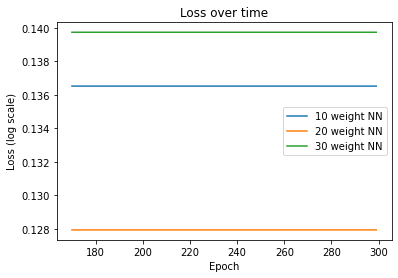

In [ ]:
def plot_losses_small(losses, names):
    for j in range(len(losses)):
        loss = losses[j]
        name = names[j]
        x = []
        y = []
        for i in range(170, 300):
            if not np.isnan(loss[i]) and loss[i] < np.Inf:
                x.append(i)
                y.append(loss[i])
        plt.plot(x, y, label=name)
        
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()

plot_losses_small([losses2,losses4, losses6], ["10 weight NN","20 weight NN","30 weight NN"])